# Create THERMOCALC KG1 phase diagram

The grid that is imported below is calculated using the Holland et al. (2018) model.

Import required libraries:

In [1]:
import pyMelt as m
from pyMelt import phaseDiagramTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
kg1 = pd.read_csv('kg1_thermocalc_grid.csv')
kg1.head()

,pressure,temperature,X,cpx,cpx_Al2O3,cpx_CaO,cpx_Cr2O3,cpx_FeO,cpx_K2O,cpx_MgO,...,grt_SiO2,grt_TiO2,grt_xAlM2,grt_xCaM1,grt_xCrM2,grt_xFe3M2,grt_xFeM1,grt_xMgM1,grt_xMgM2,grt_xTiM2
0,0.01,1050.1,NaN,0.11453,0.777073,18.439632,0.091563,5.321257,0.370267,23.194567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,1055.0,NaN,0.11652,0.791166,18.411995,0.092835,5.335828,0.365026,23.209174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.01,1060.0,NaN,0.11857,0.805720,18.383104,0.094132,5.350976,0.359784,23.224320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.01,1065.0,NaN,0.12064,0.820480,18.353528,0.095456,5.366414,0.354669,23.239682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.01,1070.0,NaN,0.12274,0.835447,18.323255,0.096805,5.382170,0.349629,23.255251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
for col in kg1.columns:
    if col == 'plc':
        kg1['plg'] = kg1['plc']
        kg1.drop('plc', axis=1, inplace=True)
    elif col[:3] == 'plc':
        kg1['plg_'+col[4:]] = kg1[col]
        kg1.drop(col, axis=1, inplace=True)
    elif col == 'ru':
        kg1['rut'] = kg1['ru']
        kg1.drop('ru', axis=1, inplace=True)
    elif col[:2] == 'ru':
        kg1['rut_'+col[4:]] = kg1[col]
        kg1.drop(col, axis=1, inplace=True)

Using lattice-strain model partition coefficients requires the pyrope proportion, which is more convenient to access directly:

In [4]:
# Properties needed to calculate garnet Ds
kg1['grt_pyrope'] = kg1['grt_xMgM1']
kg1['grt_grossular'] = kg1['grt_xCaM1'] - kg1['grt_xCrM2'] - kg1['grt_xFe3M2']
kg1['grt_almandine'] = kg1['grt_xFeM1']
kg1['grt_uvarovite'] = kg1['grt_xCrM2']
kg1['grt_spessartine'] = 0.0
kg1['grt_andradite'] = kg1['grt_xFe3M2']

# Properties needed for plagioclase Ds:
kg1['plg_anorthite'] = kg1['plg_x(Ca)']
kg1['plg_albite'] = kg1['plg_x(Na)']


In [5]:
kg1_grid = phaseDiagramTools.gridsThermocalc(kg1, phases=['olv', 'opx', 'cpx', 'spn', 'grt', 'rut', 'liq', 'plg'])

In [6]:
phased = phaseDiagramTools.phaseDiagram(kg1_grid, minerals=['olv', 'opx', 'cpx', 'spn', 'grt', 'rut', 'plg'])

In [7]:
f = open( "thermocalc_kg1.p", "wb" )
pickle.dump(phased, f)
f.close()

## Check the interpolated phase diagram

### Mass proportions

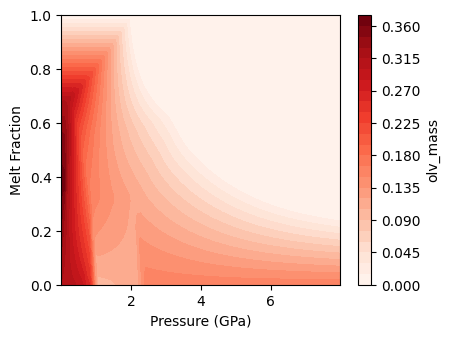

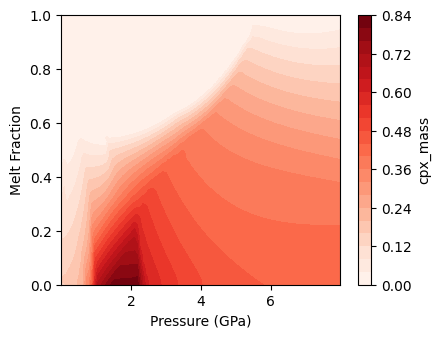

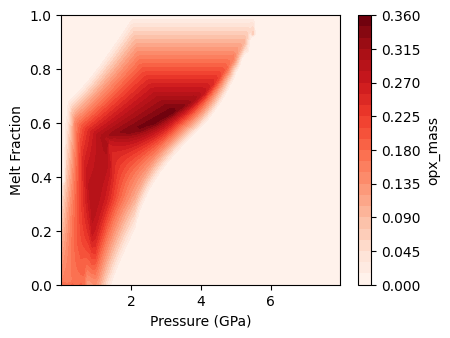

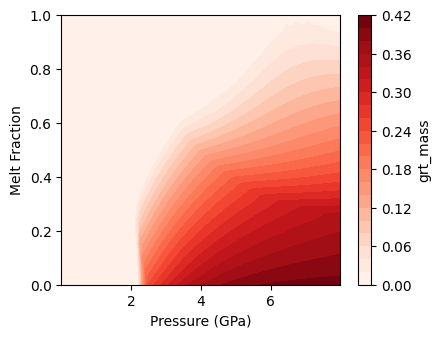

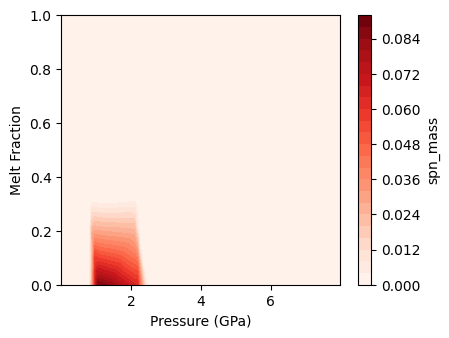

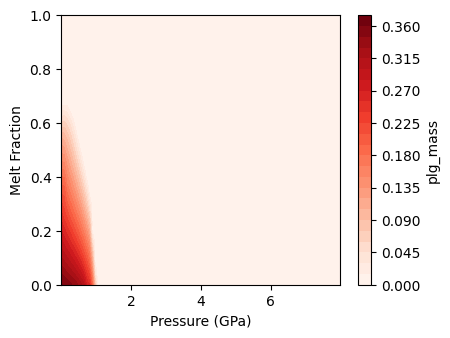

In [8]:
phases = ['olv', 'cpx', 'opx', 'grt', 'spn', 'plg']

for ph in phases:
    f, a = phased.plot_TxSection(ph + '_mass', mask_mineral_out=False)
    plt.show()

### Liquid Compositions

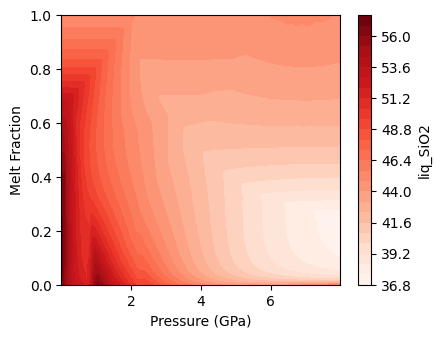

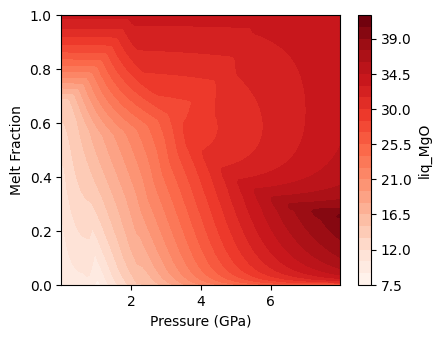

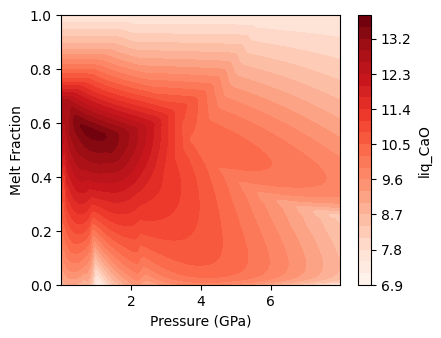

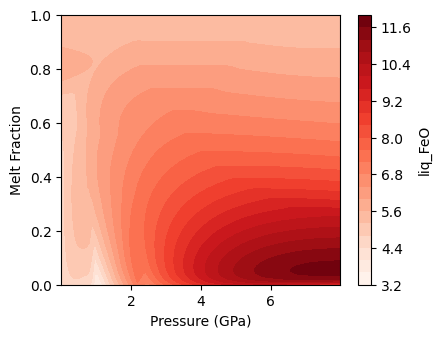

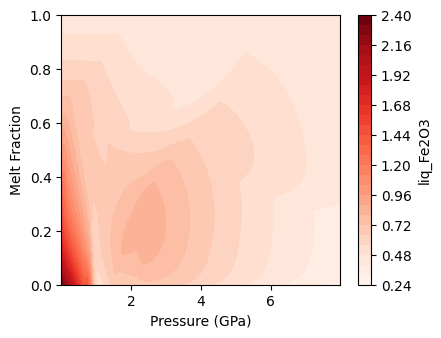

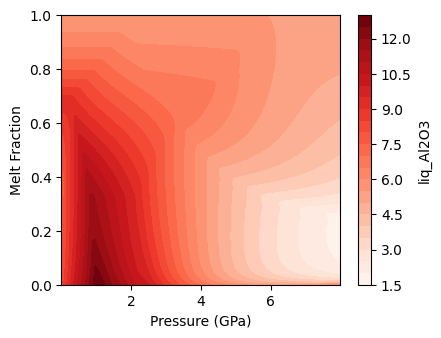

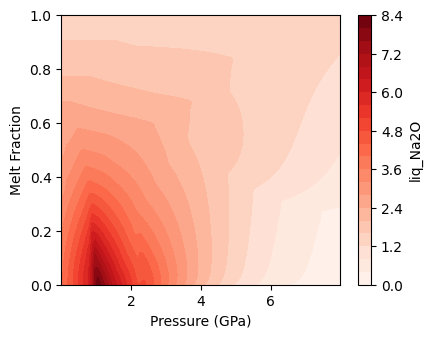

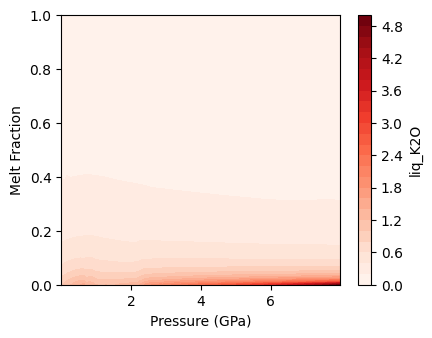

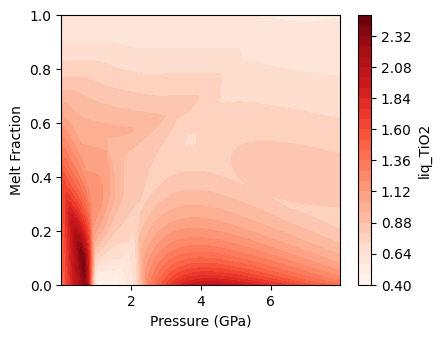

In [9]:
oxides = ['SiO2', 'MgO', 'CaO', 'FeO', 'Fe2O3', 'Al2O3', 'Na2O', 'K2O', 'TiO2']

for ox in oxides:
    f, a = phased.plot_TxSection('liq_' + ox)
    plt.show()


### Important parameters for D calculation

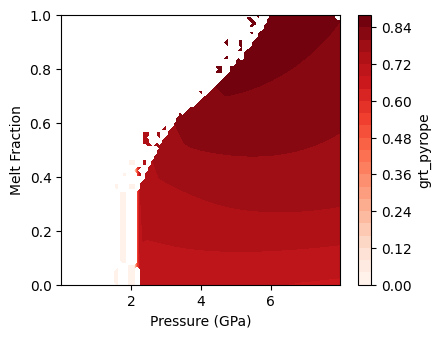

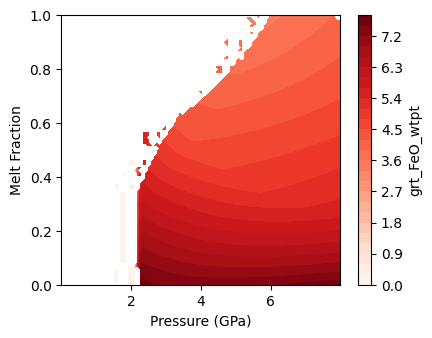

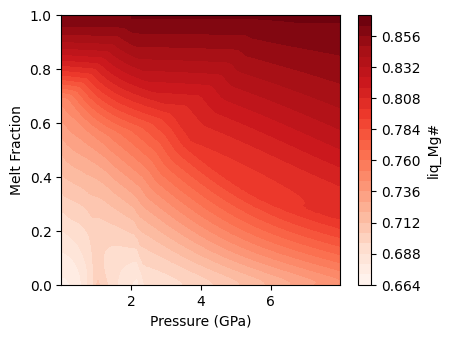

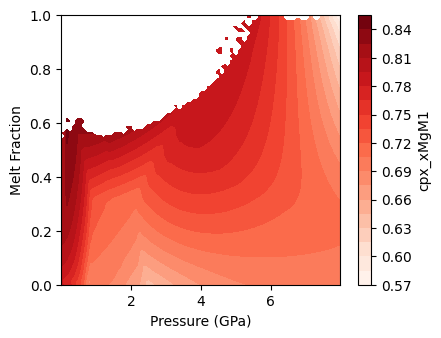

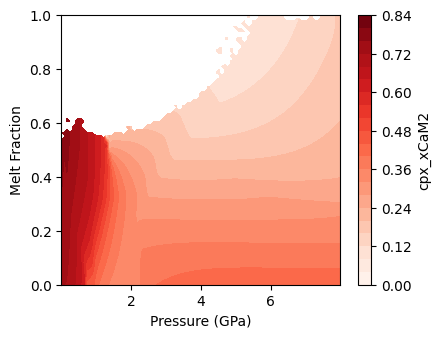

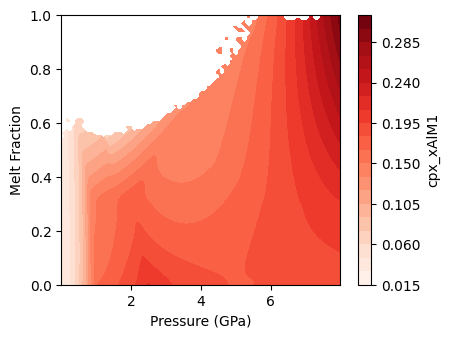

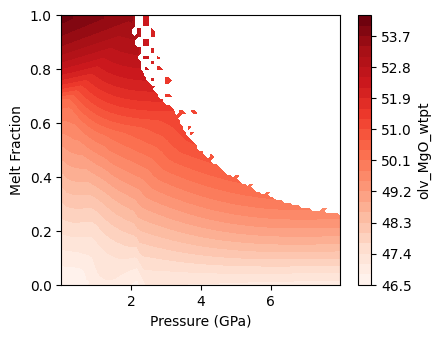

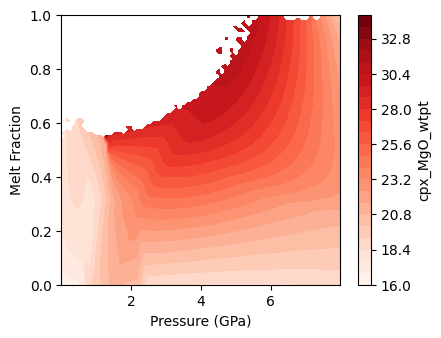

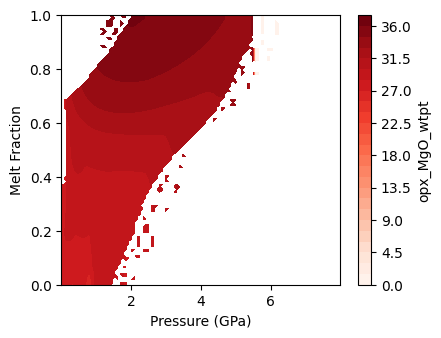

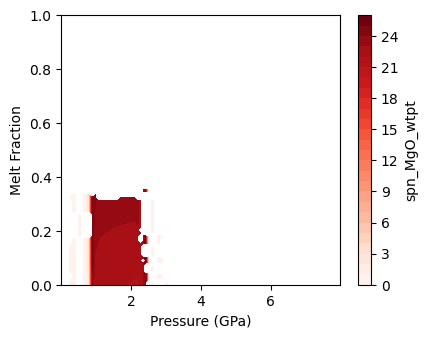

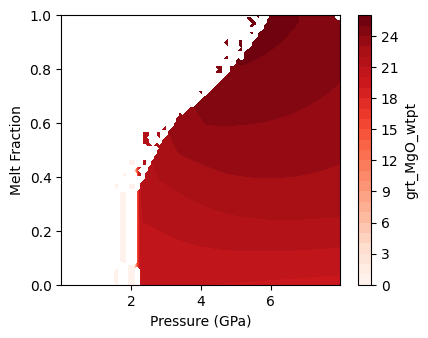

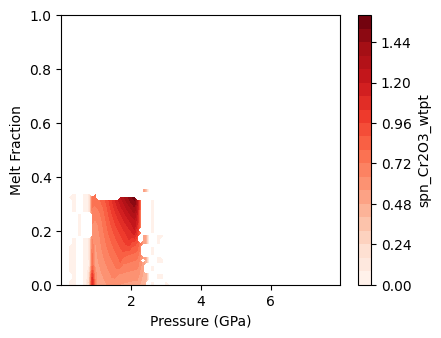

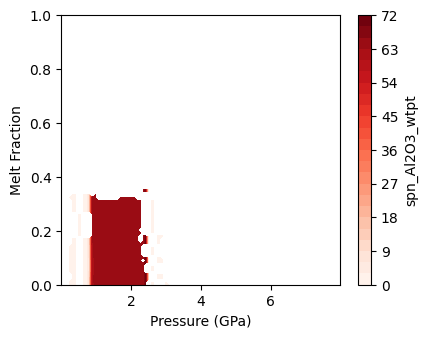

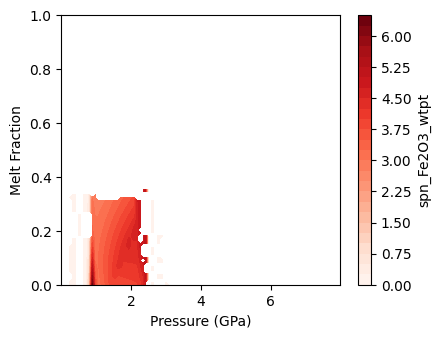

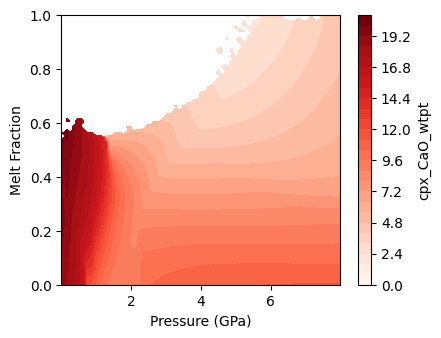

In [10]:
params = ['grt_pyrope', 'grt_FeO_wtpt', 'liq_Mg#', 'cpx_xMgM1', 'cpx_xCaM2', 'cpx_xAlM1',
          'olv_MgO_wtpt', 'cpx_MgO_wtpt', 'opx_MgO_wtpt', 'spn_MgO_wtpt', 'grt_MgO_wtpt',
          'spn_Cr2O3_wtpt', 'spn_Al2O3_wtpt', 'spn_Fe2O3_wtpt', 'cpx_CaO_wtpt']

for pr in params:
    if pr[:3] == 'liq':
        mask=False
    else:
        mask=True
    f, a = phased.plot_TxSection(pr, mask_mineral_out=mask)
    plt.show()